In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date, datetime

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler

DATA_ROOT = "input/"

In [2]:
dfoff = pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
dftest = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)
print(dfoff.shape)
print(dftest.shape)
dfoff.head(20)

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


In [3]:
## Creat target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

dfoff["label"] = dfoff.apply(label, axis=1)
dfoff["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

In [4]:
dfoff = dfoff[ dfoff['label'] != -1]
print(dfoff.shape)

(746969, 8)


In [5]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].apply(getWeekday)

# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].astype('str').apply(lambda x : 1 if x in [6,7] else 0 ) # apply to testset

In [6]:
from datetime import timedelta
def end_day_date(x):
    if str(x) == 'nan':
        return x
    else:
        a = (datetime.strptime(str(int(x)), '%Y%m%d') + timedelta(days=15)).weekday()
    return a
dfoff['end_date'] = dfoff['Date_received'].apply(end_day_date)
dftest['end_date'] = dfoff['Date_received'].apply(end_day_date)

In [7]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf
dfoff.head(5)

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,end_date,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3,0,3,0,0,1,0,0,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6,0,6,0,0,0,0,0,1,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5,0,5,0,0,0,0,1,0,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5,0,5,0,0,0,0,1,0,0
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,5,0,5,0,0,0,0,1,0,0


In [8]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0
    
def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)
    
def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
    
def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = df['Distance'].median()
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)
dfoff.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_type,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,discount_rate,discount_man,discount_jian,discount_type
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3,0,...,0,1,0,0,0,0,0.95,20,1,1
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6,0,...,0,0,0,0,1,0,0.95,20,1,1
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5,0,...,0,0,0,1,0,0,0.90,200,20,1
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5,0,...,0,0,0,1,0,0,0.90,200,20,1
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0,5,0,...,0,0,0,1,0,0,0.50,10,5,1
6,73611,2099,12034.0,100:10,2.0,20160207.0,NaN,0,7,0,...,0,0,0,0,0,1,0.90,100,10,1
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,0,4,0,...,0,0,1,0,0,0,0.85,200,30,1
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,0,6,0,...,0,0,0,0,1,0,0.90,200,20,1
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,0,2,0,...,1,0,0,0,0,0,0.90,200,20,1
11,253750,8390,7531.0,20:5,0.0,20160327.0,NaN,0,7,0,...,0,0,0,0,0,1,0.75,20,5,1


In [9]:
offshape = dfoff.shape[0]
testshape = dftest.shape[0]
df = pd.concat([dfoff, dftest], axis=0)
def client_number(df):
    a = df.groupby(['User_id','Merchant_id']).size()
    a = a.reset_index()
    a.columns = ['User_id', 'Merchant_id', 'N client of Merchant']
    df = pd.merge(df, a, how='left')
    return df

df = client_number(df)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
def consume_number(df):
    a = df.groupby('User_id').size()
    a = a.reset_index()
    a.columns = ['User_id', 'Consume_number']
    df = pd.merge(df, a, how='left')
    return df

df = consume_number(df)
dfoff = df[0:offshape]
dftest = df[offshape+1: offshape+testshape]
print(dfoff.shape)
print(dftest.shape)
dftest.head()

(746969, 24)
(306312, 24)


,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,discount_jian,discount_man,discount_rate,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,weekday_type,N client of Merchant,Consume_number
746970,8591.0,NaN,20160613.0,20:1,0.0,2632,1439408,1,20,0.950000,...,1,0,0,0,0,0,0,0,4,5
746971,8591.0,NaN,20160516.0,20:1,0.0,2632,1439408,1,20,0.950000,...,1,0,0,0,0,0,0,0,4,5
746972,1532.0,NaN,20160530.0,30:5,0.0,450,2029232,5,30,0.833333,...,1,0,0,0,0,0,0,0,1,3
746973,12737.0,NaN,20160519.0,20:1,0.0,6459,2029232,1,20,0.950000,...,0,0,0,1,0,0,0,0,1,3
746974,1097.0,NaN,20160606.0,50:10,0.0,6901,2747744,10,50,0.800000,...,1,0,0,0,0,0,0,0,1,1


In [36]:
#dftest = dftest.drop(['weekend_days'], axis=1)
dfoff = dfoff.drop(['weekend_days'], axis=1)
dfoff.head(5)

,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,discount_jian,discount_man,discount_rate,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,weekday_type,N client of Merchant,Consume_number,dist_discount
0,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,1,20,0.950000,...,0,1,0,0,0,0,0,4,5,0.0
1,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,1,20,0.950000,...,0,0,0,0,1,0,0,4,5,0.0
2,8591.0,NaN,20160613.0,20:1,0.0,2632,1439408,1,20,0.950000,...,0,0,0,0,0,0,0,4,5,0.0
3,8591.0,NaN,20160516.0,20:1,0.0,2632,1439408,1,20,0.950000,...,0,0,0,0,0,0,0,4,5,0.0
4,11002.0,NaN,20160528.0,150:20,1.0,4663,1439408,20,150,0.866667,...,0,0,0,0,1,0,0,1,5,1.0


In [11]:
def dist_count(df):
    df['dist_discount'] = df['Distance'] ** (1 / df['discount_rate'])
    return df

dfoff = dist_count(dfoff)
dftest = dist_count(dftest)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
# def get_weekend_days(x):
#     if str(x) == 'nan':
#         return x
#     else:
#         days = 4
#         day = datetime.strptime(str(int(x)), '%Y%m%d').weekday()
#         if day == 4 or day == 5:
#             days += 1
#         return days

# dfoff['weekend_days'] = dfoff['Date_received'].apply(get_weekend_days)
# dftest['weekend_days'] = dfoff['Date_received'].apply(get_weekend_days)

C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\benja\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [12]:
print(dfoff.columns)
print(dfoff.shape)
dfoff.head(10)

Index(['Coupon_id', 'Date', 'Date_received', 'Discount_rate', 'Distance',
       'Merchant_id', 'User_id', 'discount_jian', 'discount_man',
       'discount_rate', 'discount_type', 'end_date', 'label', 'weekday',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weekday_7', 'weekday_type', 'N client of Merchant',
       'Consume_number', 'dist_discount'],
      dtype='object')
(746969, 25)


,Coupon_id,Date,Date_received,Discount_rate,Distance,Merchant_id,User_id,discount_jian,discount_man,discount_rate,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,weekday_type,N client of Merchant,Consume_number,dist_discount
0,8591.0,NaN,20160217.0,20:1,0.0,2632,1439408,1,20,0.95,...,0,1,0,0,0,0,0,4,5,0.000000
1,1078.0,NaN,20160319.0,20:1,0.0,2632,1439408,1,20,0.95,...,0,0,0,0,1,0,0,4,5,0.000000
2,7610.0,NaN,20160429.0,200:20,0.0,3381,1832624,20,200,0.90,...,0,0,0,1,0,0,0,1,1,0.000000
3,11951.0,NaN,20160129.0,200:20,1.0,3381,2029232,20,200,0.90,...,0,0,0,1,0,0,0,1,3,1.000000
4,9776.0,NaN,20160129.0,10:5,2.0,3381,2223968,5,10,0.50,...,0,0,0,1,0,0,0,1,1,4.000000
5,12034.0,NaN,20160207.0,100:10,2.0,2099,73611,10,100,0.90,...,0,0,0,0,0,1,0,1,1,2.160119
6,5054.0,NaN,20160421.0,200:30,10.0,1569,163606,30,200,0.85,...,0,0,1,0,0,0,0,1,1,15.013107
7,7802.0,NaN,20160130.0,200:20,10.0,4833,3273056,20,200,0.90,...,0,0,0,0,1,0,0,1,1,12.915497
8,7610.0,NaN,20160412.0,200:20,2.0,3381,94107,20,200,0.90,...,1,0,0,0,0,0,0,1,1,2.160119
9,7531.0,NaN,20160327.0,20:5,0.0,8390,253750,5,20,0.75,...,0,0,0,0,0,1,0,1,2,0.000000


In [13]:
def split_train_valid(row, date_cut="20160416"):
   is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
   return is_train

In [14]:
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)
train = df[df["is_train"]]
valid = df[~df["is_train"]]

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472.0
Valid size: 79216, #positive: 3832.0


In [15]:
original_feature = ['discount_rate',
                    'discount_type',
                    'discount_man', 
                    'discount_jian',
                    'Distance', 
                    'weekday', 
                    'weekday_type',
                   'N client of Merchant',
                   'dist_discount',
                   'Consume_number',
                   'end_date'] + weekdaycols
predictors = original_feature
print(predictors)
print(len(original_feature),original_feature)
train[original_feature].head(10)

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'N client of Merchant', 'dist_discount', 'Consume_number', 'end_date', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']
18 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'N client of Merchant', 'dist_discount', 'Consume_number', 'end_date', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


,discount_rate,discount_type,discount_man,discount_jian,Distance,weekday,weekday_type,N client of Merchant,dist_discount,Consume_number,end_date,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0.950000,1,20,1,0.0,3,0,4,0.000000,5,3.0,0,0,1,0,0,0,0
1,0.950000,1,20,1,0.0,6,0,4,0.000000,5,6.0,0,0,0,0,0,1,0
2,0.900000,1,200,20,1.0,5,0,1,1.000000,3,5.0,0,0,0,0,1,0,0
3,0.500000,1,10,5,2.0,5,0,1,4.000000,1,5.0,0,0,0,0,1,0,0
4,0.900000,1,100,10,2.0,7,0,1,2.160119,1,0.0,0,0,0,0,0,0,1
5,0.900000,1,200,20,10.0,6,0,1,12.915497,1,6.0,0,0,0,0,0,1,0
6,0.900000,1,200,20,2.0,2,0,1,2.160119,1,2.0,0,1,0,0,0,0,0
7,0.750000,1,20,5,0.0,7,0,1,0.000000,2,0.0,0,0,0,0,0,0,1
8,0.833333,1,30,5,2.0,3,0,1,2.297397,1,3.0,0,0,1,0,0,0,0
9,0.950000,1,20,1,10.0,1,0,1,11.288379,1,1.0,1,0,0,0,0,0,0


In [73]:
predictors = original_feature
print(predictors)

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type']


In [261]:
eta = [0.9, 0.5]
max_depth = [10, 7]
gamma = [0.1, 0.2]
param_grid = dict(eta=eta, max_dept=max_depth, gamma=gamma)
clf = XGBClassifier(nthread=2)
grid_search = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, verbose=1)
grid_result = grid_search.fit(train[predictors], train['label'])
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 21.2min finished


Best Accuracy: 0.856751 using {'eta': 0.9, 'gamma': 0.2, 'max_dept': 10}


In [16]:
from xgboost import XGBClassifier 
model = XGBClassifier(eta=0.9, max_depth=10, nthread=2, min_child_weight=5, gamma=0.2)
model.fit(train[predictors], train['label'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.9, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=2, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [194]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    max_depth=10
)
model.fit(train[predictors], train['label'])
print('importance = {}'.format(model.feature_importances_))

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


importance = [0.0919633  0.00455451 0.15450179 0.06890736 0.12874965 0.01952488
 0.         0.38552305 0.12135289 0.00259012 0.00388912 0.00340763
 0.00206283 0.00664005 0.00301768 0.00331514]


In [204]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    penalty='l2'
)
model.fit(train[predictors], train['label'])

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [213]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=30, max_features=7,
                                  max_depth=6, learning_rate=0.3)
model.fit(train[predictors], train['label'])
print('importance = {}'.format(model.feature_importances_))

importance = [0.04502516 0.01655311 0.17058441 0.09994349 0.18300066 0.03113818
 0.         0.34790861 0.07668168 0.00216816 0.00321174 0.00361161
 0.00396903 0.00852504 0.00236245 0.00531666]


In [232]:
from mlxtend.classifier import StackingClassifier
gb = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=30, max_features=7,
                                  max_depth=6, learning_rate=0.3)
lr = LogisticRegression(penalty='l2')
rf = RandomForestClassifier(max_depth=10)
xg = XGBClassifier(eta=0.9, max_depth=10, nthread=2, min_child_weight=5)
meta_estimator = lr
model = StackingClassifier(classifiers=[lr,rf,gb, xg], meta_classifier=meta_estimator)
model.fit(train[predictors], train['label'])

C:\Users\benja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\benja\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\benja\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


StackingClassifier(average_probas=False,
                   classifiers=[LogisticRegression(C=1.0, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=100,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l2',
                                                   random_state=None,
                                                   solver='warn', tol=0.0001,
                                                   verbose=0,
                                                   warm_start=False),
                                RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                      

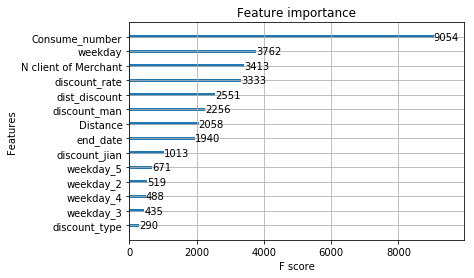

In [18]:
from xgboost import plot_importance
plot_importance(model, max_num_features = 15)

        discount_rate  discount_type  discount_man  discount_jian  Distance  \
0            0.950000              1            20              1       0.0   
1            0.950000              1            20              1       0.0   
2            0.866667              1           150             20       1.0   
3            0.900000              1           200             20       0.0   
4            0.833333              1            30              5       0.0   
5            0.950000              1            20              1       0.0   
6            0.850000              1           200             30      10.0   
7            0.833333              1            30              5       0.0   
8            0.750000              1            20              5       0.0   
9            0.666667              1            30             10       0.0   
10           0.950000              1            20              1       0.0   
11           0.950000              1            20  

In [22]:
y_pred = model.predict_proba(valid[predictors])
score = roc_auc_score(valid['label'], y_pred[:,1])
print(score)

0.8523674029054746


In [20]:
y_pred[:,1][y_pred[:,1]<0.5] = 0
y_pred[:,1][y_pred[:,1] >= 0.5] = 1
print(y_pred[y_pred[:,1]==1])

[[0.48508793 1.        ]
 [0.414178   1.        ]
 [0.4038502  1.        ]
 ...
 [0.43593985 1.        ]
 [0.19001716 1.        ]
 [0.48207432 1.        ]]


In [23]:
y_valid_pred = model.predict_proba(valid[predictors])
valid1 = valid.copy()
valid1['pred_prob'] = y_valid_pred[:, 1]

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score
auc_score = roc_auc_score(y_true=valid.label, y_score=y_valid_pred[:,1])
acc = accuracy_score(y_true=valid.label, y_pred=y_valid_pred.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.852, Accuracy: 0.953


In [25]:
targetset = dftest.copy()
print(targetset.shape)
targetset = targetset[~targetset.Coupon_id.isna()]
targetset.reset_index(drop=True, inplace=True)
testset = targetset[predictors].copy()

y_test_pred = model.predict_proba(testset[predictors])
print(y_test_pred)
test1 = testset.copy()
test1['pred_prob'] = y_test_pred[:, 1]
print(test1.shape)

(306312, 25)
[[0.898066   0.10193399]
 [0.9010314  0.09896863]
 [0.8892862  0.11071376]
 ...
 [0.97682375 0.02317626]
 [0.9881119  0.01188811]
 [0.8270583  0.17294167]]
(306312, 19)


In [26]:
output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
print(output.shape)

output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

(306312, 4)


In [27]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby("uid", as_index=False).mean()
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
out.to_csv("baseline_example.csv", header=["uid", "label"], index=False) # submission format
out.head()

,uid,label
0,1000020_2705_20160519,0.190526
1,1000020_8192_20160513,0.196173
2,1000065_1455_20160527,0.089099
3,1000085_8067_20160513,0.086748
4,1000086_2418_20160613,0.111118
